In [48]:
import pytse_client as tse
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.linalg import pinv
# tickers = tse.download(symbols="all", write_to_csv=True)

Device = ("cuda"
          if torch.cuda.is_available()
          else "cpu"
)
print(f"Using {Device} device")
days_history=100
days_predict=30

Using cuda device


In [49]:
output_coeff = 5
t = torch.zeros([output_coeff,days_predict],device=Device)
for i in range(output_coeff):
    #t[i,:] = (torch.arange(days_predict)/days_predict+1)**((i+1)/output_coeff)
    b = i/output_coeff
    x = torch.arange(days_predict)/days_predict
    t[i,:] = x*torch.exp(-(x - b)**2)
class Model(nn.Module):
    def __init__(self,input_size):
        m=32
        n=64
        kernel=[3,3]
        pad=[1,1]
        super().__init__()
        self.conv1= nn.Conv2d(1,m,kernel_size=kernel,padding=pad)
        self.conv2= nn.Conv2d(m,2*m,kernel_size=kernel,padding=pad)
        self.conv3= nn.Conv2d(2*m,4*m,kernel_size=kernel,padding=pad)
        self.conv44=nn.Conv2d(4*m,4*m,kernel_size=kernel,padding=pad)
        self.conv4= nn.Conv2d(4*m,2*m,kernel_size=kernel,padding=pad)
        self.conv5= nn.Conv2d(2*m,m,kernel_size=kernel,padding=pad)
        self.Lin1 = nn.Linear(input_size*5*m,2*n)
        self.Lin2 = nn.Linear(2*n,4*n)
        self.Lin3 = nn.Linear(4*n,2*n)
        self.Lin4 = nn.Linear(2*n,n)
        self.Lin5 = nn.Linear(n,output_coeff)
        self.activation1 = nn.LeakyReLU(negative_slope=0.01)
        self.activation2 = nn.Tanh()
        self.drop = nn.Dropout(p=0.8)
        self.norminput = nn.BatchNorm2d(1)
        self.normC = nn.BatchNorm2d(4*m)
        self.normL2 = nn.BatchNorm1d(4*n)
        self.normL3 = nn.BatchNorm1d(2*n)
        self.normL4 = nn.BatchNorm1d(1*n)
        self.flat = nn.Flatten(start_dim=1)
        
    def forward(self, x):
        x = self.norminput(x)
        x = self.conv1(x)
        x = self.activation1(x)
        x = self.drop(x) ###
        x = self.conv2(x)
        x = self.activation1(x)
        x = self.drop(x) ###
        x = self.conv3(x)
        x = self.activation1(x)
        x = self.drop(x) ###
        

        x = self.conv44(x)
        x = self.activation1(x)
        x = self.drop(x) ###
        x = self.normC(x) #### 
        

        x = self.conv4(x)
        x = self.activation1(x)
        x = self.drop(x) ###
        x = self.conv5(x)
        x = self.activation1(x)
        x = self.drop(x) ###
        x = self.flat(x)
        x = self.Lin1(x)
        x = self.activation1(x) 
        x = self.drop(x) ###
        x = self.Lin2(x)
        x = self.activation1(x)
        x = self.normL2(x)#######
        x = self.drop(x) ###
        x = self.Lin3(x)
        x = self.activation1(x)
        x = self.normL3(x)#######
        x = self.drop(x) ###
        x = self.Lin4(x)
        x = self.activation1(x)
        x = self.normL4(x)#######
        x = self.drop(x) ###
        x = self.Lin5(x)
        x = self.activation1(x)
        x = self.drop(x) ###
        return x

model=Model(days_history).to(device=Device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
#optimizer = torch.optim.SGD(model.parameters(),lr=0.001)
LossFn = nn.MSELoss()
gama=0.99
W_gama=torch.diag(torch.tensor([gama**(1*i) for i in range(days_predict)],device=Device))
for p in model.parameters():
    #p.data.fill_(torch.randn([])/10)
    print(np.shape(p))

torch.Size([32, 1, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([64, 128, 3, 3])
torch.Size([64])
torch.Size([32, 64, 3, 3])
torch.Size([32])
torch.Size([128, 16000])
torch.Size([128])
torch.Size([256, 128])
torch.Size([256])
torch.Size([128, 256])
torch.Size([128])
torch.Size([64, 128])
torch.Size([64])
torch.Size([5, 64])
torch.Size([5])
torch.Size([1])
torch.Size([1])
torch.Size([128])
torch.Size([128])
torch.Size([256])
torch.Size([256])
torch.Size([128])
torch.Size([128])
torch.Size([64])
torch.Size([64])


In [50]:

names = ["آباد","آبادا","آپ","اپرداز","آساس","افرا","اهرم","انرژی","بترانس","بنیرو","پترول","وبملت"]
names =[names[1]]
#sym="وبملت"
stock_num = len(names)
stocks = []
for ii in range(stock_num):
    sym = names[ii]
    ticker=tse.Ticker(sym)
    length=ticker.history.shape[0]
    train_length = int(np.floor(length*0.70))
    test_length = length - train_length

    # Now we extract some portion of the first sequences of data for train
    X_train=np.zeros([train_length - days_history - days_predict , days_history,5])
    Y_train=np.zeros([train_length - days_history - days_predict , days_predict])
    for i in range(train_length - days_history - days_predict):
        m = ticker.history.loc[i : i + days_history - 1].to_numpy()
        first_day_price = m[0,9]
        X_train[i,:,:] = np.array([m[:,9]/first_day_price , m[:,7]/1e3 , m[:,6]/1e6 , m[:,2]/first_day_price , m[:,3]/first_day_price]).T
        m = ticker.history.loc[i + days_history : i + days_history - 1 + days_predict].to_numpy()
        Y_train[i,:] = m[:,9]/first_day_price

    # Now we extract some portion of the last sequences of data for test
    X_test=np.zeros([test_length - days_predict , days_history, 5])
    Y_test=np.zeros([test_length - days_predict , days_predict])
    for i in range(test_length - days_predict):
        j = i + train_length - days_history
        m = ticker.history.loc[j : j + days_history - 1].to_numpy()
        first_day_price = m[0,9]
        X_test[i,:,:] = np.array([m[:,9]/first_day_price , m[:,7]/1e3 , m[:,6]/1e6 , m[:,2]/first_day_price , m[:,3]/first_day_price]).T
        m = ticker.history.loc[j + days_history : j + days_history - 1 + days_predict].to_numpy()
        Y_test[i,:] = m[:,9]/first_day_price

    train_arr = np.arange(train_length - days_history - days_predict - 1)
    train_idx = np.random.permutation(train_arr)
    X_train = X_train[train_idx]
    Y_train = Y_train[train_idx]

    test_arr = np.arange(test_length - days_predict - 1)
    test_idx = np.random.permutation(test_arr)
    X_test = X_test[test_idx]
    Y_test = Y_test[test_idx]
    
    X_train = torch.from_numpy(X_train).to(device=Device,dtype=torch.float32)
    Y_train = torch.from_numpy(Y_train).to(device=Device,dtype=torch.float32)

    X_test = torch.from_numpy(X_test).to(device=Device,dtype=torch.float32)
    Y_test = torch.from_numpy(Y_test).to(device=Device,dtype=torch.float32)

    stocks.append([X_test,Y_test,X_train,Y_train])

In [82]:
batch_size = 64
train_Losses=[]
test_Losses=[]

for epoch in range(1):
    model.train()
    train_loss=torch.tensor(0,dtype=torch.float32)
    N_total_train = 0
    for ii in range(stock_num):
        [_,_,X_train,Y_train] = stocks[ii]
        N_train = int(np.floor(X_train.size(0)/batch_size))
        N_total_train += N_train
        for i in range(N_train):
            x = X_train[i*batch_size:(i+1)*batch_size,:,:].unsqueeze(1)
            y = Y_train[i*batch_size:(i+1)*batch_size,:]
            optimizer.zero_grad()
            P_true = (y - y[:,0].unsqueeze(1))@ pinv(t) 
            P_out = model(x)  
            loss_train = LossFn(P_out,P_true)
            loss_train.backward()
            #nn.utils.clip_grad_norm(model.parameters(),1)
            optimizer.step()
            train_loss += loss_train.detach().item()
    train_Losses.append( train_loss/(N_total_train*batch_size))
   
    model.eval()
    test_loss=torch.tensor(0,dtype=torch.float32)
    test_acc=torch.tensor(0,dtype=torch.float32)
    with torch.no_grad():
        N_total_test = 0
        for ii in range(stock_num):
            [X_test,Y_test,_,_] = stocks[ii]
            N_test = int(np.floor(X_test.size(0)/batch_size))
            N_total_test += N_test
            for i in range(N_test):
                x = X_test[i*batch_size:(i+1)*batch_size,:,:].unsqueeze(1)
                y = Y_test[i*batch_size:(i+1)*batch_size,:].detach()
                P_true = (y - y[:,0].unsqueeze(1))@ pinv(t) 
                P_out = model(x) 
                loss_test = LossFn(P_out,P_true)
                test_loss += loss_test.detach().item()
                out = P_out @ t + y[:,0].unsqueeze(1)
                test_acc += torch.sum(1-torch.abs((y@W_gama-out@W_gama)/y@W_gama)).detach().item()
    test_Losses.append( test_loss/(N_total_test*batch_size) )
    accuracy = test_acc / (N_total_test*batch_size*days_predict) *100
    print(f'{epoch}: train loss is {train_Losses[epoch]:.4f} & test loss is {test_Losses[epoch]:.4f} & accuracy is %{accuracy:.2f}')

0: train loss is 20.5523 & test loss is 17.0260 & accuracy is %95.82


In [83]:
z = torch.zeros([batch_size,days_predict],device=Device)
const_acc = 0
const_loss = 0
N_total_test = 0
for ii in range(stock_num): 
    [X_test,Y_test,_,_] = stocks[ii]
    N_test = int(np.floor(X_test.size(0)/batch_size))
    N_total_test += N_test  
    for i in range(N_test):
        x = X_test[i*batch_size:(i+1)*batch_size,:,:]
        y = Y_test[i*batch_size:(i+1)*batch_size,:].detach()
        out = z + y[:,0].unsqueeze(1)
        P_true = (y - y[:,0].unsqueeze(1))@ pinv(t) 
        loss_const = LossFn(P_true,torch.zeros(batch_size,output_coeff,device=Device))
        const_loss += loss_const.detach().item()
        const_acc += torch.sum(1-torch.abs(y@W_gama-out@W_gama)/y@W_gama).detach().item()
const_loss /= N_total_test*batch_size
accuracy = const_acc / (N_total_test*batch_size*days_predict) *100
print(f'constant price method loss is {const_loss:.4f} accuracy is %{accuracy:.2f}')



random_strock = np.random.randint(stock_num)
[X_test,Y_test,X_train,Y_train] = stocks[random_strock]
test_length = X_test.size(0)
iidx=np.random.randint(test_length,size=[5,2])

constant price method loss is 17.0260 accuracy is %95.70


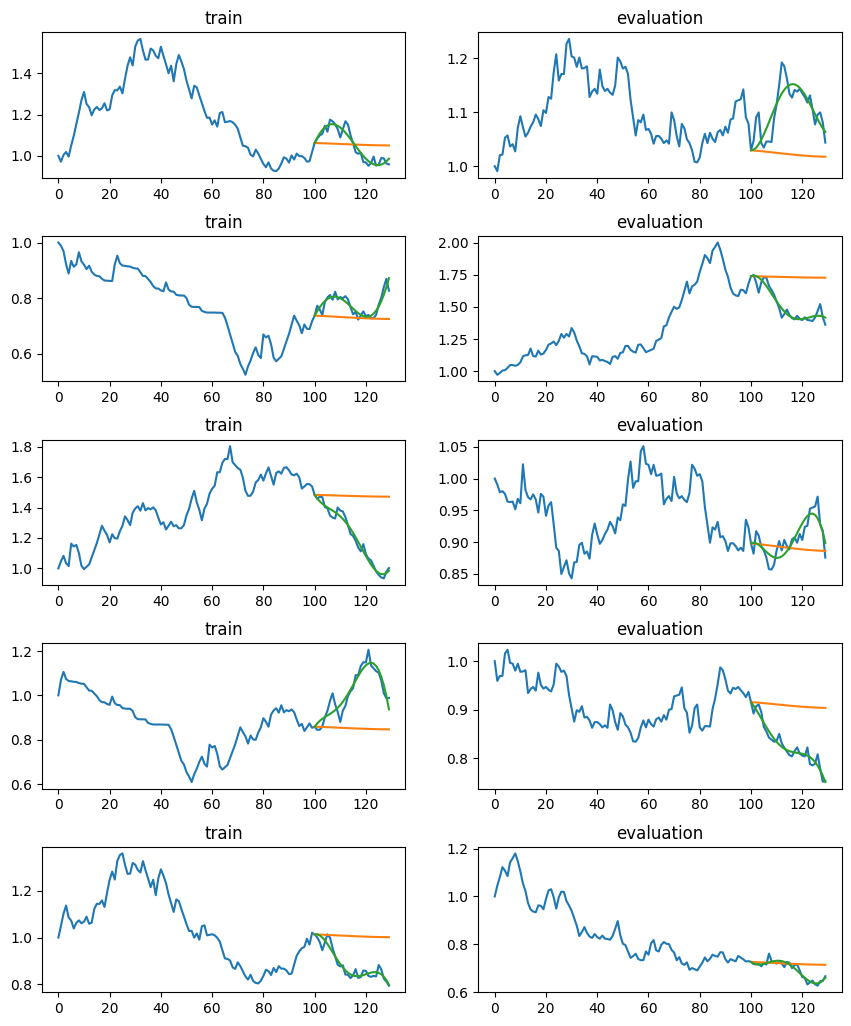

In [84]:
plt.figure(figsize=[10,12])
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)

model.eval()
for i in range(5):
   plt.subplot(5,2,2*i+1)
   r=iidx[i,0]
   yy=torch.concatenate([X_train[r,:,0].cpu(),Y_train[r,:].cpu()]) 
   xx=np.arange(days_history+days_predict)
   plt.plot(xx,yy)
   tempp=X_train[r,:,:].unsqueeze(0).unsqueeze(1)
   #yyy=(model(tempp).detach()).squeeze(0).cpu()  
   yyy=( (model(tempp).detach()@t+Y_train[r,0]) ).squeeze(0).cpu()  
   plt.plot(xx[days_history:days_history+days_predict] ,yyy )
   yyyy=((Y_train[r,:]-Y_train[r,0])@pinv(t)@t + Y_train[r,0]).cpu()
   plt.plot(xx[days_history:days_history+days_predict] ,yyyy )
   plt.title('train')

   plt.subplot(5,2,2*i+2)
   r=iidx[i,1]
   yy=torch.concatenate([X_test[r,:,0].cpu(),Y_test[r,:].cpu()])
   xx=np.arange(days_history+days_predict)
   plt.plot(xx,yy)
   tempp=X_test[r,:,:].unsqueeze(0).unsqueeze(1)
   #yyy=(model(tempp).detach()).squeeze(0).cpu()  
   yyy=( (model(tempp).detach()@t+Y_test[r,0]) ).squeeze(0).cpu() 
   plt.plot(xx[days_history:days_history+days_predict] ,yyy )
   yyyy=((Y_test[r,:]-Y_test[r,0])@pinv(t)@t + Y_test[r,0]).cpu()
   plt.plot(xx[days_history:days_history+days_predict] ,yyyy )
   plt.title('evaluation')




